<a href="https://colab.research.google.com/github/maddysshaw/Cognitive_AI_2024/blob/main/Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NeuroGym is a curated collection of neuroscience tasks, with a common interface,
designed to facilitate training of neural network models on neuroscience tasks.

2. (a) Initially, your goal is to train and compare multiple (at least two) models to
perform one of these tasks. One model should be a standard recurrent neural
network model (e.g. vanilla RNN, leaky RNN, light GRU, GRU, LSTM). One or
more of the other models you implement should differ from the standard model
based on a brain-inspired change (which you described in your answer to
question 1). Describe your models including equations and schematic diagrams,
highlighting the key differences. [10 marks]

In [2]:
# Import common packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time

**Setting Up a Vanilla RNN**

In [5]:
class VanillaRNN(nn.Module):
    """Vanilla RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """
    def __init__(self, input_size, hidden_size, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.

        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)

        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.tanh(self.input2h(input) + self.h2h(hidden))
        return h_new

    def forward(self, input, hidden=None):
        """Propagate input through the network."""

        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model using Vanilla RNN.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Vanilla RNN
        self.rnn = VanillaRNN(input_size, hidden_size, **kwargs)

        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

**Implementing Feedback Alignment to RNN**

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

class FeedbackAlignedRNN(nn.Module):
    """Feedback-aligned Vanilla RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """
    def __init__(self, input_size, hidden_size, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Define forward weights
        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

        # Define fixed random feedback weights
        self.feedback_weights = nn.Parameter(torch.randn(hidden_size, hidden_size), requires_grad=False)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step."""
        h_new = torch.tanh(self.input2h(input) + self.h2h(hidden))
        return h_new

    def forward(self, input, hidden=None):
        """Propagate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        for i in range(input.size(0)):
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack outputs from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class FA_RNNNet(nn.Module):
    """Recurrent network model using Feedback-Aligned RNN.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Feedback-Aligned RNN
        self.rnn = FeedbackAlignedRNN(input_size, hidden_size, **kwargs)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

        # Feedback weights for the output layer
        self.output_feedback_weights = nn.Parameter(torch.randn(output_size, hidden_size), requires_grad=False)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

    def feedback_alignment_update(self, optimizer, output, target):
        """Custom backward pass using feedback alignment."""
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, target)

        # Compute gradients for the output layer
        output_grad = torch.autograd.grad(loss, output, create_graph=True)[0]

        # Update output layer weights using fixed feedback weights
        with torch.no_grad():
            self.fc.weight.grad = torch.mm(output_grad, self.output_feedback_weights).t()
            self.fc.bias.grad = output_grad.sum(dim=0)

        # Compute gradients for RNN hidden weights using feedback weights
        for i in reversed(range(output.size(0))):
            hidden_grad = torch.mm(output_grad, self.rnn.feedback_weights)
            for param in self.rnn.parameters():
                if param.requires_grad:
                    param.grad = torch.autograd.grad(output[i], param, grad_outputs=hidden_grad, retain_graph=True)[0]

        # Apply optimizer step
        optimizer.step()
        optimizer.zero_grad()

**Implementing Biological Features to the Architecture**
Including hierarchical structure, recurrent connections, and sparsity constraints

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

class HierarchicalSparseRNN(nn.Module):
    """Hierarchical RNN with recurrent connections and sparsity constraint.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons per layer
        num_layers: Number of RNN layers
        sparsity_lambda: Weight of the sparsity penalty (L1 regularization)

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: list of tensors, each of shape (batch, hidden_size), initial hidden state for each layer

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size * num_layers)
        hidden: list of tensors, each of shape (batch, hidden_size), final hidden state for each layer
    """
    def __init__(self, input_size, hidden_size, num_layers, sparsity_lambda=0.01, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.sparsity_lambda = sparsity_lambda

        # Define layers with recurrent connections
        self.input2h = nn.ModuleList([nn.Linear(input_size if i == 0 else hidden_size, hidden_size) for i in range(num_layers)])
        self.h2h = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_layers)])

        # Optional recurrent connections across layers
        self.cross_layer_recurrent = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_layers - 1)])

    def init_hidden(self, batch_size):
        return [torch.zeros(batch_size, self.hidden_size) for _ in range(self.num_layers)]

    def recurrence(self, input, hidden):
        """Process one time step with recurrent and cross-layer connections."""
        layer_hidden = []
        current_input = input
        sparsity_loss = 0

        # Propagate through each layer
        for i in range(self.num_layers):
            h_new = torch.tanh(self.input2h[i](current_input) + self.h2h[i](hidden[i]))

            # Add cross-layer recurrent connection
            if i > 0:
                h_new += torch.tanh(self.cross_layer_recurrent[i - 1](hidden[i - 1]))

            # Accumulate sparsity loss
            sparsity_loss += h_new.abs().mean()  # L1 sparsity constraint

            # Store new hidden state and set input for next layer
            layer_hidden.append(h_new)
            current_input = h_new

        return layer_hidden, sparsity_loss

    def forward(self, input, hidden=None):
        """Propagate input through the network."""
        batch_size = input.shape[1]

        # Initialize hidden states if not provided
        if hidden is None:
            hidden = self.init_hidden(batch_size)
        output = []
        total_sparsity_loss = 0

        # Process each time step
        for t in range(input.size(0)):
            hidden, sparsity_loss = self.recurrence(input[t], hidden)
            output.append(torch.cat(hidden, dim=-1))  # Concatenate all layers’ hidden states for output
            total_sparsity_loss += sparsity_loss

        # Stack outputs and apply sparsity constraint
        output = torch.stack(output, dim=0)
        total_sparsity_loss /= input.size(0)  # Average over timesteps

        return output, hidden, self.sparsity_lambda * total_sparsity_loss


class HS_RNNNet(nn.Module):
    """Recurrent network with hierarchical sparse RNN.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size per layer
        output_size: int, output size
        num_layers: int, number of RNN layers

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, hidden_size * num_layers)
    """
    def __init__(self, input_size, hidden_size, output_size, num_layers, sparsity_lambda=0.01, **kwargs):
        super().__init__()

        # Hierarchical Sparse RNN
        self.rnn = HierarchicalSparseRNN(input_size, hidden_size, num_layers, sparsity_lambda=sparsity_lambda, **kwargs)

        # Output layer
        self.fc = nn.Linear(hidden_size * num_layers, output_size)

    def forward(self, x):
        rnn_output, _, sparsity_loss = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output, sparsity_loss


2. (b) Compare your models both in how well they learn to perform the task, and by
analysing the hidden unit activity of the trained models to understand how the
trained models solve the task. Highlight and interpret any differences between
the models. [20 marks]



Import task from neurogym library

In [1]:
# Install neurogym to use cognitive tasks
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .

Cloning into 'neurogym'...
remote: Enumerating objects: 11100, done.
remote: Counting objects: 100% (1001/1001), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 11100 (delta 928), reused 898 (delta 898), pack-reused 10099 (from 1)
Receiving objects: 100% (11100/11100), 8.17 MiB | 9.33 MiB/s, done.
Resolving deltas: 100% (8335/8335), done.
/content/neurogym
Obtaining file:///content/neurogym
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.4/696.4 kB 8.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.24.1-py3-none-any.whl size=793122 sha256=fe98b0dafa94281aa59fb7c648e23fdf751bf5adb1b6de45561c7606ddf76e80
  Stored in directory: /root/.cache/pip/wheels/c4/fb/19/388995b88cb551717a8dff40c889172cd12fadf994216a0a22
Successfully built gym
  Attempting uninstall: gym
    Found existing in

In [7]:
%%capture
# @title import the task from the neurogym library

import neurogym as ngym

import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Environment
task = 'PerceptualDecisionMaking-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

Train Networks on Decision Making Tasks

RNNNet(
  (rnn): VanillaRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc): Linear(in_features=50, out_features=3, bias=True)
)
Step 200, Loss 0.2649
Step 400, Loss 0.1225
Step 600, Loss 0.0772
Step 800, Loss 0.0683
Step 1000, Loss 0.0662
Step 1200, Loss 0.0633
Step 1400, Loss 0.0622
Step 1600, Loss 0.0618
Step 1800, Loss 0.0617
Step 2000, Loss 0.0587
Step 2200, Loss 0.0594
Step 2400, Loss 0.0582
Step 2600, Loss 0.0578
Step 2800, Loss 0.0580
Step 3000, Loss 0.0586
Step 3200, Loss 0.0566
Step 3400, Loss 0.0566
Step 3600, Loss 0.0566
Step 3800, Loss 0.0561
Step 4000, Loss 0.0571
Step 4200, Loss 0.0554
Step 4400, Loss 0.0568
Step 4600, Loss 0.0567
Step 4800, Loss 0.0574
Step 5000, Loss 0.0574


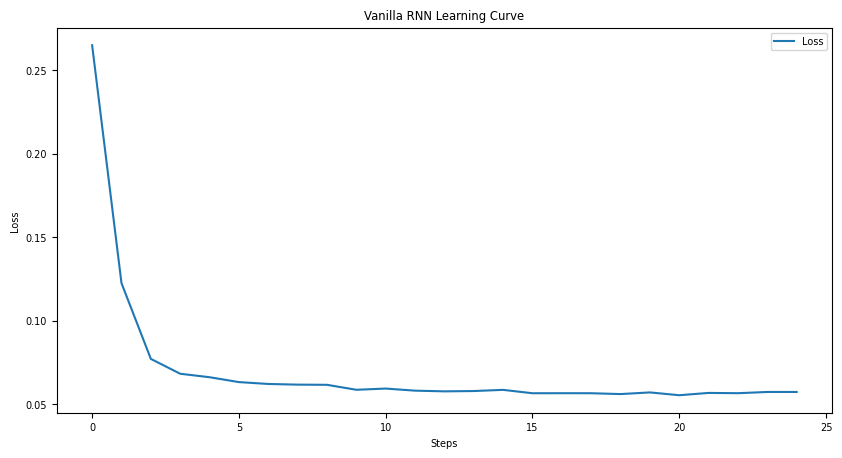

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Assuming Net is defined somewhere and dataset() function is defined
# Assuming input_size and output_size are also defined

# Instantiate the network
hidden_size = 50
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

loss_values = []  # List to store loss values
running_loss = 0.0
print_step = 200
for i in range(5000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  # Append average loss here
        running_loss = 0.0

# Plotting the learning curve
plt.figure(figsize=(10,5))
plt.title("Vanilla RNN Learning Curve")
plt.plot(loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

FA_RNNNet(
  (rnn): FeedbackAlignedRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc): Linear(in_features=50, out_features=3, bias=True)
)
Step 200, Loss 0.3006
Step 400, Loss 0.1370
Step 600, Loss 0.0850
Step 800, Loss 0.0744
Step 1000, Loss 0.0678
Step 1200, Loss 0.0633
Step 1400, Loss 0.0626
Step 1600, Loss 0.0617
Step 1800, Loss 0.0591
Step 2000, Loss 0.0601
Step 2200, Loss 0.0578
Step 2400, Loss 0.0574
Step 2600, Loss 0.0573
Step 2800, Loss 0.0591
Step 3000, Loss 0.0589
Step 3200, Loss 0.0575
Step 3400, Loss 0.0576
Step 3600, Loss 0.0559
Step 3800, Loss 0.0565
Step 4000, Loss 0.0572
Step 4200, Loss 0.0556
Step 4400, Loss 0.0571
Step 4600, Loss 0.0576
Step 4800, Loss 0.0580
Step 5000, Loss 0.0560


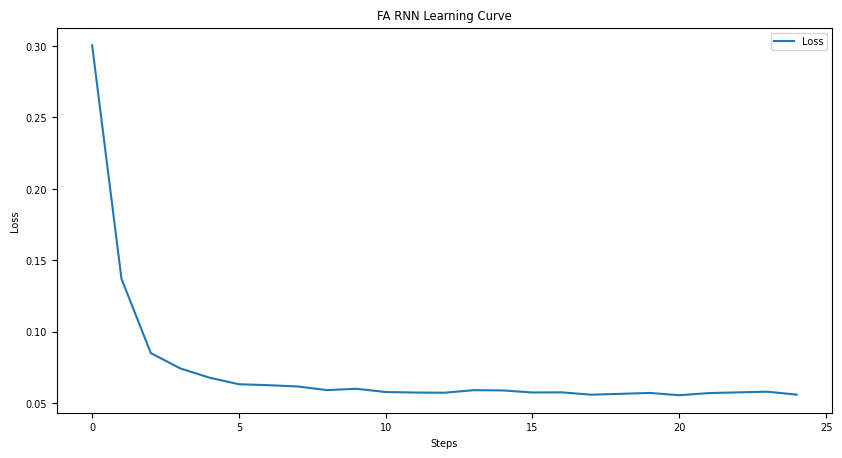

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Assuming Net is defined somewhere and dataset() function is defined
# Assuming input_size and output_size are also defined

# Instantiate the network
hidden_size = 50
net = FA_RNNNet(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

loss_values = []  # List to store loss values
running_loss = 0.0
print_step = 200
for i in range(5000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  # Append average loss here
        running_loss = 0.0

# Plotting the learning curve
plt.figure(figsize=(10,5))
plt.title("FA RNN Learning Curve")
plt.plot(loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Assuming Net is defined somewhere and dataset() function is defined
# Assuming input_size and output_size are also defined

# Instantiate the network
hidden_size = 50
net = HS_RNNNet(input_size=input_size, hidden_size=hidden_size, num_layers=4, sparsity_lambda=0.01,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

loss_values = []  # List to store loss values
running_loss = 0.0
print_step = 200
for i in range(5000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  # Append average loss here
        running_loss = 0.0

# Plotting the learning curve
plt.figure(figsize=(10,5))
plt.title("HS RNN Learning Curve")
plt.plot(loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

HS_RNNNet(
  (rnn): HierarchicalSparseRNN(
    (input2h): ModuleList(
      (0): Linear(in_features=3, out_features=50, bias=True)
      (1-3): 3 x Linear(in_features=50, out_features=50, bias=True)
    )
    (h2h): ModuleList(
      (0-3): 4 x Linear(in_features=50, out_features=50, bias=True)
    )
    (cross_layer_recurrent): ModuleList(
      (0-2): 3 x Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (fc): Linear(in_features=200, out_features=3, bias=True)
)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: too many values to unpack (expected 2)

2. (c) Using the same models, train them to solve a second task from NeuroGym, and
analyse them as in b). Do your conclusions from b) hold for this second task? [20 marks]


2. (d) These marks are reserved for something original. Some possibilities could be
training networks with a totally different architecture, implementing a different
type of learning (e.g. reinforcement), implementing neuromodulation, training
on multiple tasks at once, or many tasks or anything else unexpected. Anything
presented in this section should be done so in comparison with what you know
about how brains and standard ML/AI models learn. This part is only worth 20%
of the coursework marks [10% of total], so please do not spend a
disproportionate amount of time on it. [20 marks]